In [1]:
import sys
sys.path.append('../../')
sys.path.append('../')


import pandas as pd
import numpy as np

from codes.docs.analysis.nimagen import stats, visualisation, graph,genes
from codes.docs.analysis import data_preprocessing, genetic_file_preprocess
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict


In [2]:
from joblib import Parallel, delayed
import time
import tqdm
import glob
import os

Performing stability tests as described in the paper

# Fronto-temporal and Parieto-occipital halving experiment

In [3]:
european_volumetric_dataset_term = pd.read_csv('../../dataset/preprocessed_dataset/imaging_data/log_file/rel3/volumetric/european_volumetric_df_rel3_batch2.csv')

european_volumetric_dataset_term = european_volumetric_dataset_term[(european_volumetric_dataset_term['radiology_score']<5)&(european_volumetric_dataset_term['radiology_low_image_quality']==False)]

df = european_volumetric_dataset_term.copy()

ancestry = [f'euro_Anc_PC{i}'
            for i in range(1, 4)]  # remove any ancestry outliers

df = stats.MassUnivariate.remove_outliers(
    df,
    col=ancestry,
    threshold=3.5,
    remove_schemes='any',
    percentage_of_outlier=0.1)

df = df.drop(columns=['ASD_PRS_Pt_1e-07'])

pca, prs_pca, loading_matrix = stats.FeatureReduction.perform_PCA(
    df,
    dependentVar_cols=[i for i in df.columns if 'ASD_PRS' in i],
    scaling=True,
    n_components=1
)

df['PRS_pca'] = prs_pca

new_df = data_preprocessing.Volumes.Imperial.group_Imperial_volumes(df,grouping=['lobe','hemisphere','gmwm2gether'])

new_df['Frontal lobe TTV'] = new_df['Imperial 36']
new_df['Parietal lobe TTV'] = new_df['Imperial 38']
new_df['Occipital lobe TTV'] = new_df['Imperial 15']
new_df['Temporal lobe TTV'] = new_df['Imperial 5']

# new_df['Frontal+Parietal TTV'] = new_df['Frontal lobe TTV'] + new_df['Parietal lobe TTV']
# new_df['Frontal+Occipital TTV'] = new_df['Frontal lobe TTV'] + new_df['Occipital lobe TTV']
new_df['Frontal+Temporal TTV'] = new_df['Frontal lobe TTV'] + new_df['Temporal lobe TTV']
new_df['Parietal+Occipital TTV'] = new_df['Parietal lobe TTV'] + new_df['Occipital lobe TTV']
# new_df['Parietal+Temporal TTV'] = new_df['Parietal lobe TTV'] + new_df['Temporal lobe TTV']
# new_df['Occipital+Temporal TTV'] = new_df['Temporal lobe TTV'] + new_df['Occipital lobe TTV']


In [9]:
all_pval = stats.MassUnivariate.print_summary_table(
df = new_df,
thresholds = [i for i in new_df.columns if 'ASD' in i],
cat_independentVar_cols=['sex'],
cont_independentVar_cols=['GA','PMA','TBV']+ancestry,
dependentVar_cols=['Frontal lobe TTV','Parietal lobe TTV','Frontal+Temporal TTV','Parietal+Occipital TTV','Temporal lobe TTV','Occipital lobe TTV'],scaling='both')

100%|█████████████████████████████████████████████| 4/4 [00:15<00:00,  3.90s/it]


In [41]:
test = all_pval.copy()
test = test[[i for i in test.columns if 'ASD' in i]].copy()
test = test.unstack()
test.columns = test.columns.droplevel()

test['BETA']=test['Beta'].sum(axis=1)
test['R_2']=test['R2'].sum(axis=1)
test['P_VAL']=test['P_val'].sum(axis=1)
test = test.drop(columns=['Beta','R2','P_val'])

test = test.reset_index()
test.columns = ['regions','thresholds','Beta','R2','P_val']

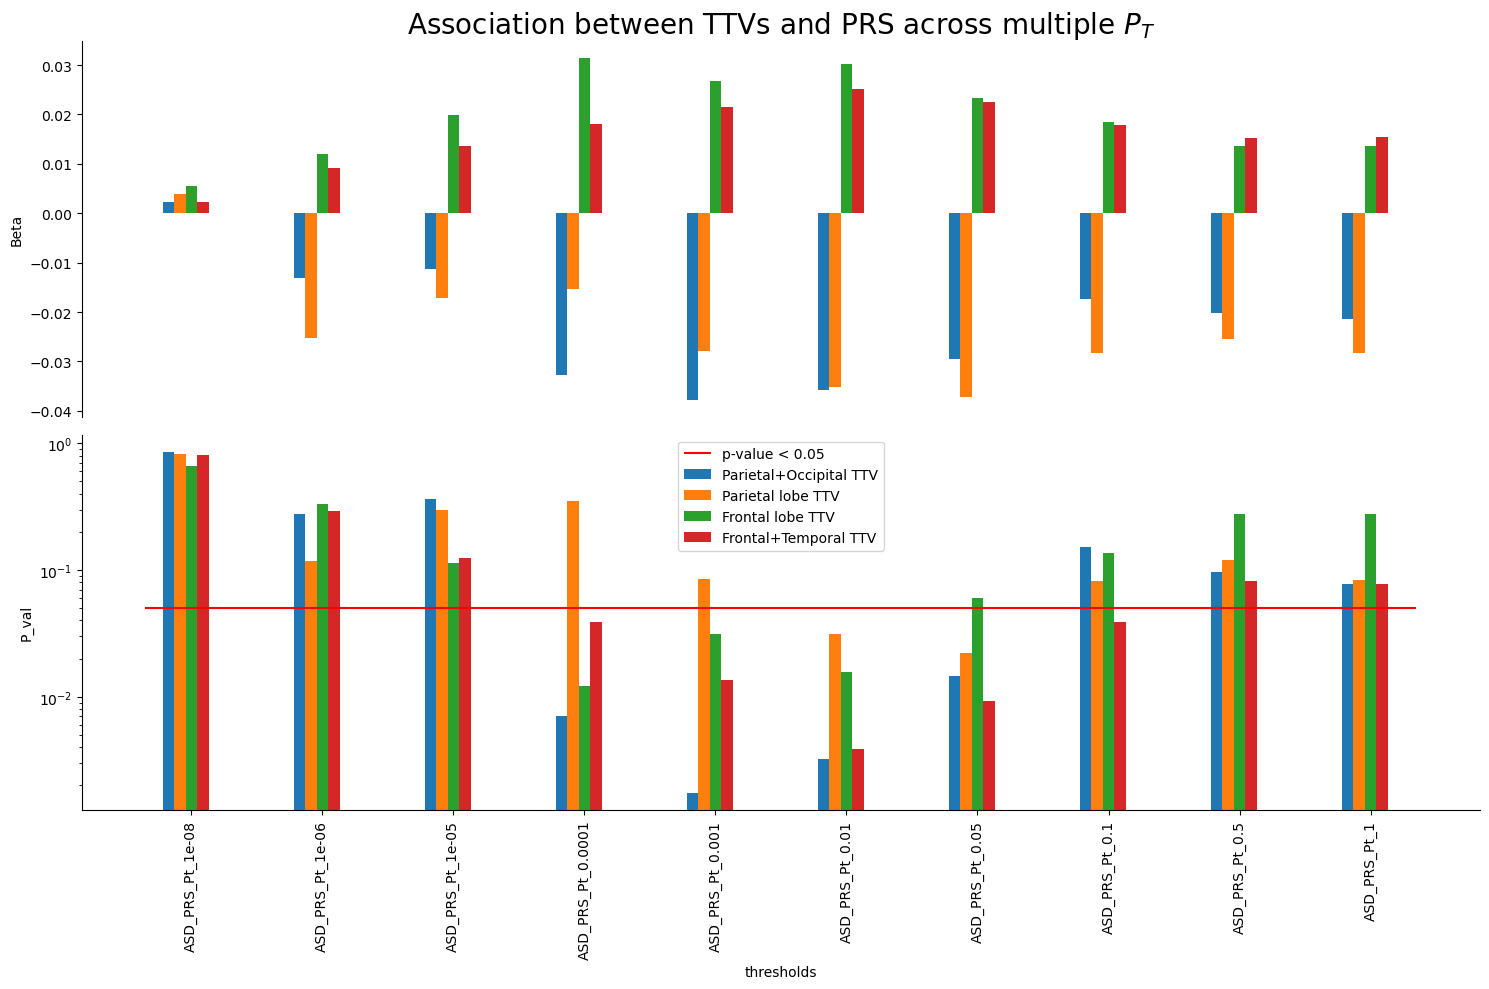

In [105]:
fig,axes=plt.subplots(2,1,figsize=(15,10),sharex=True)

visualisation.SimplePlots.Bar(x='thresholds',
                              y='Beta',
                              hue='regions',
                              data=test,
                              order={'x':[i for i in new_df.columns if 'ASD' in i]},rotation_x=90,ax=axes[0])
visualisation.SimplePlots.Bar(x='thresholds',
                              y='P_val',
                              hue='regions',
                              data=test,
                              order={'x':[i for i in new_df.columns if 'ASD' in i]},rotation_x=90,ax=axes[1],yscalelog=True,
                             hline=0.05,hline_label='p-value < 0.05')
sns.despine(ax=axes[0],bottom=True)
axes[0].tick_params(axis='x',which='both',bottom=False)
axes[0].set_xlabel(None)
axes[0].legend([],[],frameon=False)
axes[1].legend(frameon=True)
sns.despine(ax=axes[1])
axes[0].set_title('Association between TTVs and PRS across multiple $P_T$',fontsize=20)
plt.tight_layout()
fig.savefig('all_p_vals_regression.png',dpi=300)

In [50]:
def group_split(job):
    groups = stats.Stability_tests.split_group(new_df,n=2)
    for gr_idx,group in enumerate(groups):
#         pca, prs_pca, prs_loading_matrix = stats.FeatureReduction.perform_PCA(
#                 group,
#                 dependentVar_cols=[i for i in df.columns if 'ASD_PRS' in i],
#                 scaling=True,
#                 n_components=1)
        
#         group['PRS_pca'] = prs_pca
        
        _, european_mass_univariate_group = stats.MassUnivariate.mass_univariate(
                group,
                cat_independentVar_cols=['sex'],
                cont_independentVar_cols=['PRS_pca','PMA','GA','TBV']+ancestry,
                dependentVar_cols=['Frontal+Temporal TTV','Parietal+Occipital TTV','Frontal lobe TTV','Parietal lobe TTV'])
                
#         european_mass_univariate_group = european_mass_univariate_group.sort_values(by="standardize(Q('PRS_pca'))_pval").head(1)
        
        european_mass_univariate_group['group'] = gr_idx
        european_mass_univariate_group['random_state'] = job
        test_file='stability_test_regional_volume_all_TTV.csv'
        european_mass_univariate_group.to_csv(test_file,mode='a',header=not os.path.exists(test_file))

In [54]:
!rm stability_test_regional_volume_all_TTV.csv

In [32]:
! rm stability_test_regional_volume.csv

In [51]:
start=time.time()
tasks = [delayed(group_split)(i) for i in range(10)]
Parallel(n_jobs=-1)(tqdm.tqdm(tasks))
end = time.time()
print((end-start))

100%|███████████████████████████████████████████| 10/10 [00:08<00:00,  1.21it/s]


9.021914720535278


In [55]:
[group_split(i) for i in range(10)]

[None, None, None, None, None, None, None, None, None, None]

In [315]:
random_run = pd.read_csv('stability_test_regional_volume.csv',index_col=0)

In [316]:
test1 = random_run.loc['Frontal+Temporal TTV',["standardize(Q('PRS_pca'))_coef","standardize(Q('PRS_pca'))_pval",'group','random_state']]
test2 = random_run.loc['Parietal+Occipital TTV',["standardize(Q('PRS_pca'))_coef","standardize(Q('PRS_pca'))_pval",'group','random_state']]

In [317]:
len([i for i in range(1000) if i in test1.loc[test1["standardize(Q('PRS_pca'))_pval"]<0.05,'random_state'].values])

937

In [7]:
len([i for i in range(1000) if i in test2.loc[test2["standardize(Q('PRS_pca'))_pval"]<0.05,'random_state'].values])

860

In [322]:
grouped = test1.merge(test2,on=['group','random_state'],suffixes=['_FT','_PO'])

In [326]:
grouped[(grouped["standardize(Q('PRS_pca'))_pval_FT"]<0.05) & (grouped["standardize(Q('PRS_pca'))_pval_PO"]<0.05)]

,standardize(Q('PRS_pca'))_coef_FT,standardize(Q('PRS_pca'))_pval_FT,group,random_state,standardize(Q('PRS_pca'))_coef_PO,standardize(Q('PRS_pca'))_pval_PO
0,688.622687,0.015397,0,0,-636.076504,0.040543
4,583.681124,0.039398,0,2,-664.371567,0.029758
9,751.870182,0.004967,1,4,-677.061814,0.021180
10,649.452384,0.021515,0,5,-746.372372,0.018747
13,628.378253,0.020146,1,6,-627.234540,0.029516
...,...,...,...,...,...,...
1984,686.008615,0.023744,0,992,-754.103856,0.030243
1986,562.233070,0.035461,0,993,-586.320330,0.035848
1989,723.101189,0.017411,1,994,-619.318325,0.043106
1990,592.471096,0.021096,0,995,-568.841043,0.039495


In [331]:
random_run = random_run.reset_index()
random_run.columns = ['region'] + random_run.columns.tolist()[1:]

test = random_run.copy()
test = test[['region',"standardize(Q('PRS_pca'))_coef","standardize(Q('PRS_pca'))_pval","group","random_state"]]

test1 = defaultdict(dict)
for i in range(1000):
    test1[i]['Fronto-temporal TTV'] = (test[(test['region']=='Frontal+Temporal TTV') & (test['random_state']==i)]["standardize(Q('PRS_pca'))_pval"]<0.05).sum(axis=0)
    test1[i]['Parieto-occipital TTV'] = (test[(test['region']=='Parietal+Occipital TTV') & (test['random_state']==i)]["standardize(Q('PRS_pca'))_pval"]<0.05).sum(axis=0)

test1 = pd.DataFrame.from_dict(test1).T
test1 = test1.unstack().reset_index()
test1.columns = ['region'] +['random_run'] + ['count']
    
test2 = defaultdict(dict)
for i in range(1000):
    for n in range(2):
        result = np.array(['FT only','PO only'])[(test[(test['group']==n) & (test['random_state']==i)]["standardize(Q('PRS_pca'))_pval"]<0.05)]
        test2[i][n] = 'both' if len(result)==2 else result[0] if len(result)==1 else 'none'

test2 = pd.DataFrame(test2).T
test2.columns = ['group1','group2']
test2 = test2.unstack().reset_index()
test2.columns = ['group','random_run','count']

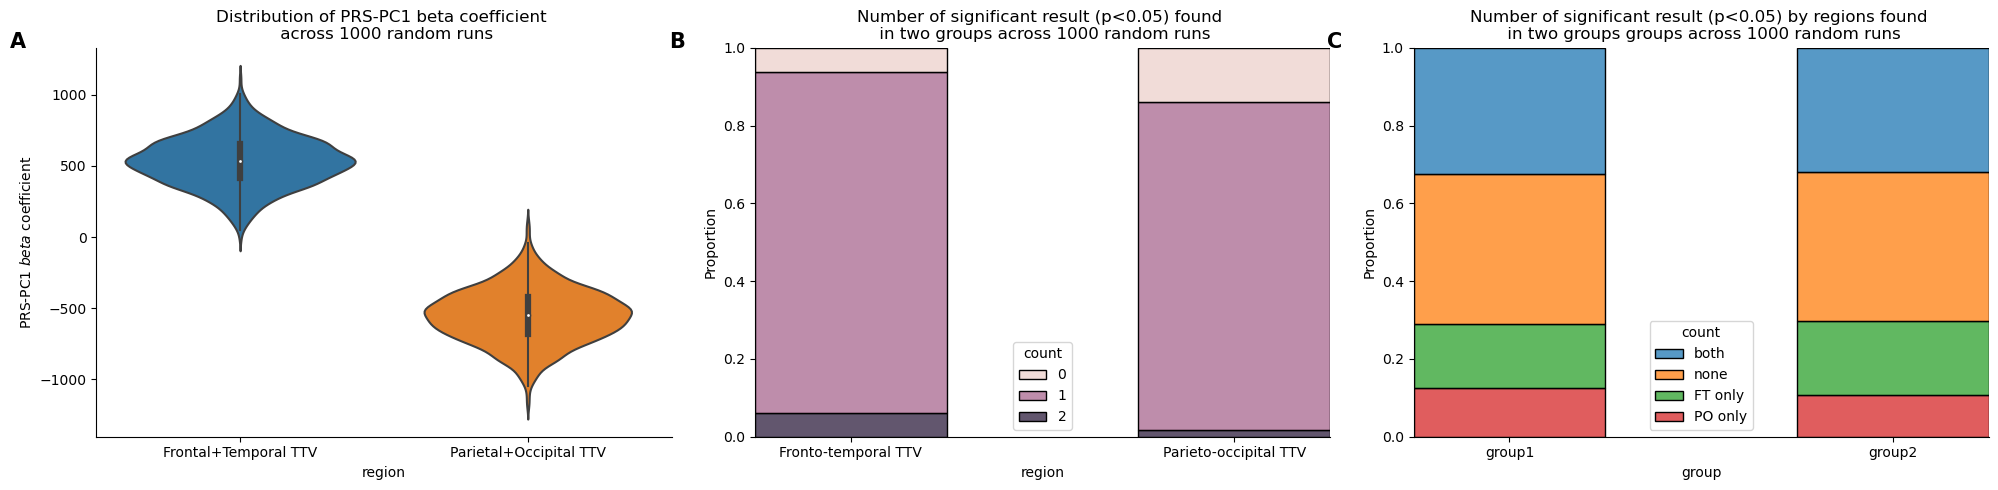

In [313]:
fig,axes = plt.subplots(1,3,figsize=(20,5))
g = sns.violinplot(x='region',y="standardize(Q('PRS_pca'))_coef",data=test,ax=axes[0])
axes[0].set_ylabel('PRS-PC1 $beta$ coefficient')
g = sns.histplot(data=test1,x='region',hue='count',
             shrink = 0.5,
             discrete=True,
             multiple="fill",
             stat='proportion',ax=axes[1])
g = sns.histplot(data=test2,x='group',hue='count',
             shrink = 0.5,
             discrete=True,
             multiple="fill",
             stat='proportion')
sns.despine()
axes[0].set_title('Distribution of PRS-PC1 beta coefficient \n across 1000 random runs')
axes[1].set_title('Number of significant result (p<0.05) found \n in two groups across 1000 random runs')
axes[2].set_title('Number of significant result (p<0.05) by regions found \n in two groups groups across 1000 random runs')

for ax,number in zip(axes,['A','B','C']):
    ax.text(-0.15,1, number, transform=ax.transAxes, fontsize=15, fontweight='bold')
plt.tight_layout()
fig.savefig('Stability_test_1.pdf')
fig.savefig('Stability_test_1.png',dpi = 300)

In [341]:
test2.loc[test2['group']=='group2','count'].value_counts()

none       383
both       320
FT only    189
PO only    108
Name: count, dtype: int64

In [327]:
_, count1 = np.unique(test1.loc[test1["standardize(Q('PRS_pca'))_pval"]<0.05,'random_state'].values,return_counts=True)
_, count2 = np.unique(test2.loc[test2["standardize(Q('PRS_pca'))_pval"]<0.05,'random_state'].values,return_counts=True)

In [328]:
len(count1[count1>1])

61

In [329]:
len(count2[count2>1])

18

In [63]:
random_run = pd.read_csv('stability_test_regional_volume_all_TTV.csv',index_col=0)
random_run = random_run.reset_index()
random_run.columns = ['region']+random_run.columns.tolist()[1:]

In [66]:
random_run.set_index(['random_state','group','region'])[["standardize(Q('PRS_pca'))_coef","standardize(Q('PRS_pca'))_pval"]].to_excel('stability_test_regional_volume.xlsx')

# Fronto-temporal and Parieto-occipital high and low risk

In [4]:
test = new_df.copy()
# test = test.rename(columns={k:f"Q('{k}')" for k in new_df.columns if 'ASD_PRS' in k})

In [6]:
test = stats.MassUnivariate.adjust_covariates_with_lin_reg(test,
                                                   cont_independentVar_cols=ancestry,
                                                   dependentVar_cols=[i for i in test.columns if 'ASD_PRS' in i])

In [10]:
thresholds = [thr for thr in new_df.columns if 'ASD_PRS' in thr]
all_combo = pd.DataFrame()
for threshold in thresholds:
    for perc in [0.1,0.2,0.3,0.4]:
        high_risk,low_risk = stats.Stability_tests.divide_high_low_risk(test[threshold],high_perc=perc,low_perc=perc)
        adjusted_df = stats.MassUnivariate.adjust_covariates_with_lin_reg(
            new_df,cat_independentVar_cols=['sex'],
            cont_independentVar_cols=['GA','PMA','TBV'],
            dependentVar_cols=['Frontal+Temporal TTV','Parietal+Occipital TTV'])
        adjusted_df['risk'] = ['high' if i in high_risk else 'low' if i in low_risk else np.nan for i in adjusted_df.index.tolist()]
        adjusted_df['threshold'] = threshold
        adjusted_df['percentage'] = perc
        all_combo = pd.concat([all_combo,adjusted_df.dropna()])
all_combo = all_combo.reset_index(drop=True)

In [11]:
all_combo

,Frontal+Temporal TTV,Parietal+Occipital TTV,risk,threshold,percentage
0,-3566.506812,3515.279414,high,ASD_PRS_Pt_1e-08,0.1
1,2377.690606,-2591.061407,low,ASD_PRS_Pt_1e-08,0.1
2,6000.968265,-768.635758,high,ASD_PRS_Pt_1e-08,0.1
3,-967.775322,3188.714013,low,ASD_PRS_Pt_1e-08,0.1
4,1837.578214,-3086.837976,low,ASD_PRS_Pt_1e-08,0.1
...,...,...,...,...,...
5495,1778.234294,-1403.897820,low,ASD_PRS_Pt_1,0.4
5496,-891.953890,-2611.285641,high,ASD_PRS_Pt_1,0.4
5497,3550.522814,-2384.946223,high,ASD_PRS_Pt_1,0.4
5498,4682.209269,-6289.374914,high,ASD_PRS_Pt_1,0.4


In [15]:
9.55+5.25+16

30.8

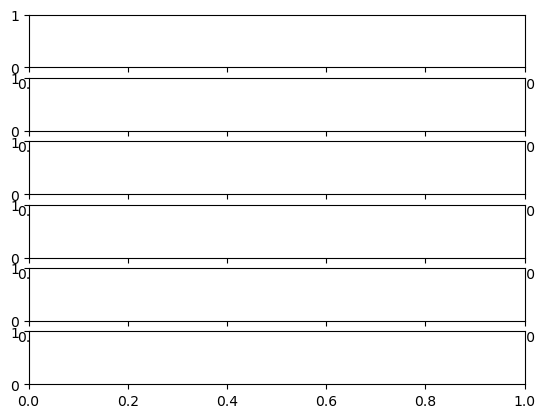

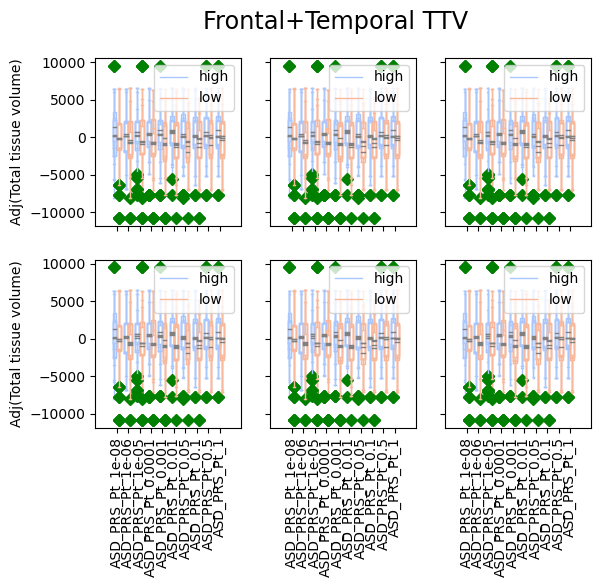

In [14]:
visualisation.SimplePlots.Box(x='threshold',
                              y='Frontal+Temporal TTV',
                              hue='risk',
                              separateby = 'percentage',
                              data=all_combo,ylabel='Adj(Total tissue volume)',
                              order=thresholds,rotation_x=90,title='Frontal+Temporal TTV')

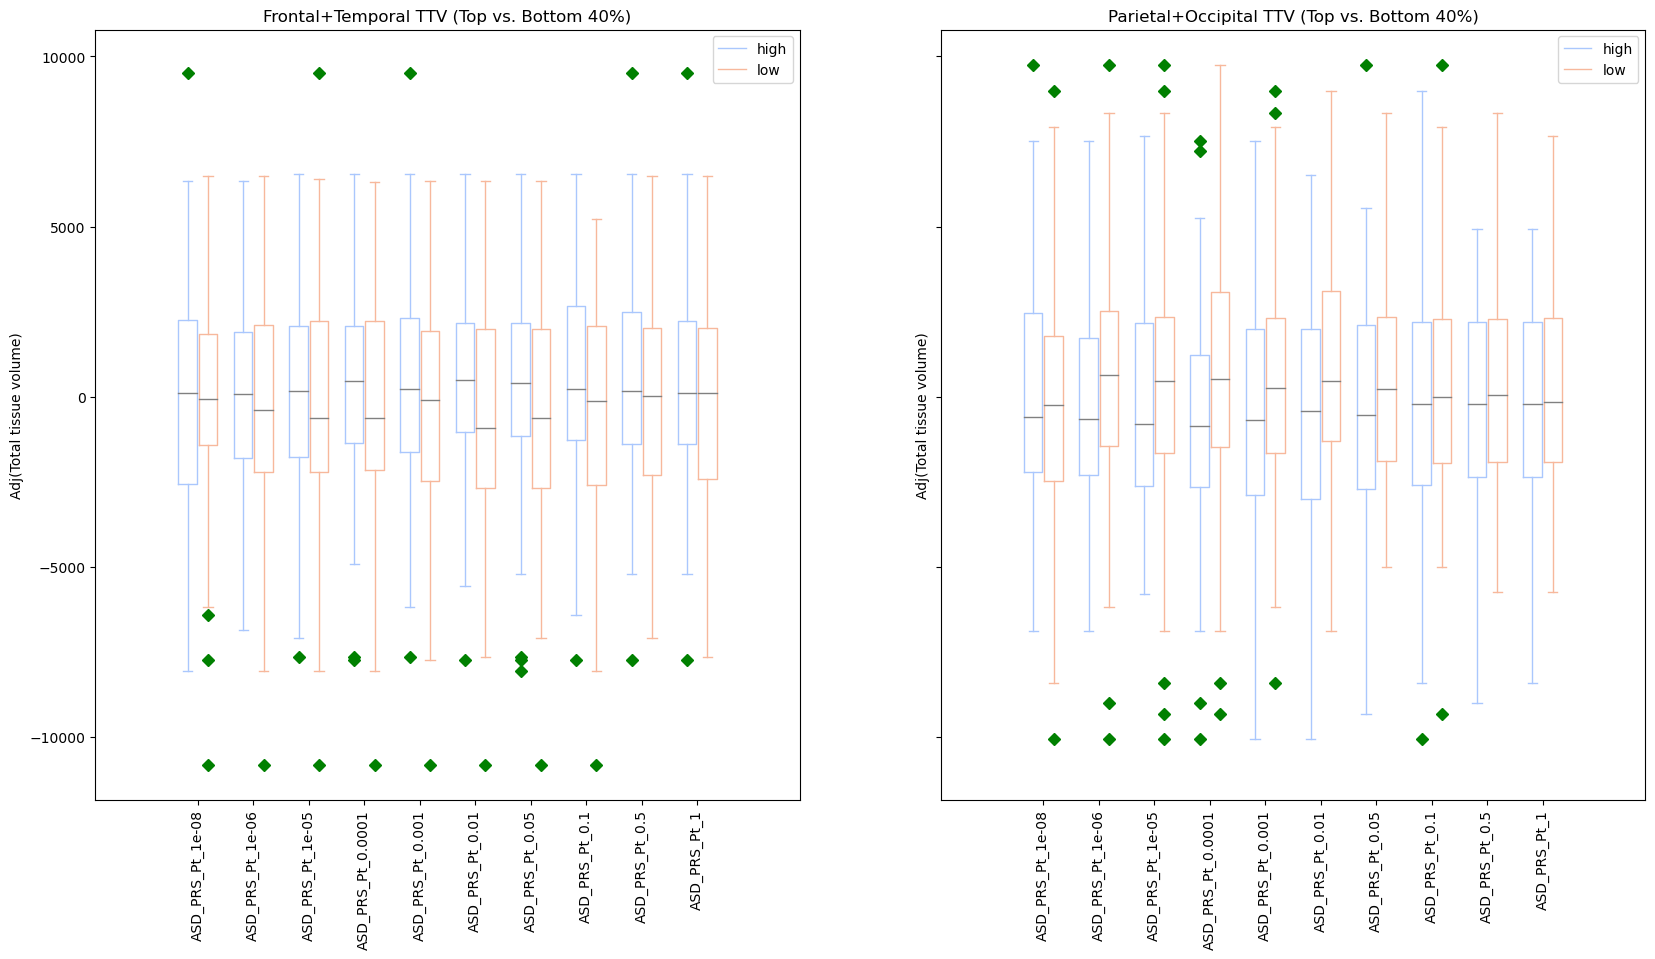

In [8]:
fig,axes = plt.subplots(3,2,figsize=(20,10),sharex=True,sharey=True)
visualisation.SimplePlots.Box(x='threshold',
                              y='Frontal+Temporal TTV',
                              hue='risk',
                              data=all_combo,ylabel='Adj(Total tissue volume)',
                              ax=axes[0],
                              order=thresholds,rotation_x=90,title='Frontal+Temporal TTV (Top vs. Bottom 40%)')
visualisation.SimplePlots.Box(x='threshold',
                              y='Parietal+Occipital TTV',
                              hue='risk',
                              data=all_combo,
                              ax=axes[1],
                              order=thresholds,ylabel='Adj(Total tissue volume)',rotation_x=90,
                             title='Parietal+Occipital TTV (Top vs. Bottom 40%)')

In [3]:
def my_function(x):
    # Your function code here
    time.sleep(5)
    with open("output.txt", "a") as f:
        f.write(f"Result for x={x}: {x + 1}\n")

In [11]:
snp_file = pd.read_table('../../dataset/SNPs/asd/ASD.snp')
best_SNPs=genes.SNPsFunctionalAnalysis.get_the_best_SNPs(snp_file,threshold=0.05)

In [8]:
def create_random_genesets(job):
    random_SNPs = best_SNPs.sample(906)
    random_SNPs_annot = genes.SNPsFunctionalAnalysis(
        snps_list=random_SNPs.SNP.to_list(),
        bed_file=
        '../../dataset/genetic_dataset/target_files/batch2/euro_batch2_genotyped.bed'
    )
    random_SNPs_annot.genes_ID, random_SNPs_annot.snp_ID = random_SNPs_annot.SNPs_annotation_to_gene(
        snps_list=random_SNPs.SNP.tolist(),
        gene_build_path=
        f'../../dataset/genetic_dataset/gene_build/NCBI37.3.gene.loc',
        window_size=0)
    random_SNPs_annot.genes_ID[['Gene_ID']].to_csv(
        f'../../dataset/preprocessed_dataset/asd/GSEA/random/random_genes_all{job}.txt',
        header=False,
        index=False,
        sep=' ')

In [9]:
def generate_best_enriched_path(job):
    msigdb_dataset ='../../dataset/genetic_dataset/pathway_database/MSigDB/MSigDB_custom_entrez.gmt'
    background_gene = '../../dataset/genetic_dataset/gene_build/NCBI37_gene_loc.txt'
    gene_job = f'../../dataset/preprocessed_dataset/asd/GSEA/random/random_genes_all{job}.txt'
    res = genes.GeneSetEnrichment.ora(msigdb_dataset,background_gene,gene_job,disable_tqdm=True)
    res['run'] = job
    res = res.sort_values(by='adjP')
    output_file = '../../dataset/preprocessed_dataset/asd/GSEA/random/random_enriched_paths.csv'
    if not os.path.isfile(output_file):
        res.head(3).to_csv(output_file, header='column_names')
    else: # else it exists so append without writing the header
        res.head(3).to_csv(output_file, mode='a', header=False)

In [13]:
start=time.time()
tasks = [delayed(create_random_genesets)(i) for i in range(100,1000)]
Parallel(n_jobs=-1)(tqdm.tqdm(tasks))
end = time.time()
print((end-start))

100%|█████████████████████████████████████████| 900/900 [01:49<00:00,  8.20it/s]


115.99976420402527


In [14]:
start=time.time()
tasks = [delayed(generate_best_enriched_path)(i) for i in range(1000)]
Parallel(n_jobs=-1)(tqdm.tqdm(tasks))
end = time.time()
print((end-start))

100%|█████████████████████████████████████| 1000/1000 [1:41:07<00:00,  6.07s/it]


6388.099687099457


In [3]:
random_run = pd.read_csv('../../dataset/preprocessed_dataset/asd/GSEA/random/random_enriched_paths.csv')
random_run = random_run.groupby('run').head(1)
random_run = pd.DataFrame(random_run.GeneSet.value_counts())
random_run = random_run[random_run['GeneSet']>50]

In [4]:
FUMA_result = '../../dataset/preprocessed_dataset/asd/GSEA/FUMA/FT_uniq_GS.txt'

# FUMA_res = pd.read_csv(f'{FUMA_result}/GS_random.txt',sep='\t')
FUMA_res = pd.read_csv(FUMA_result,sep='\t')

best_FUMA_res = FUMA_res[FUMA_res['Category'] == 'MSigDB_custom_entrez'].head(10).reset_index(drop=True).copy()
best_FUMA_res['p'] = best_FUMA_res['p'].astype('float')
best_FUMA_res['N_overlap'] = best_FUMA_res['N_overlap'].astype('int64')
best_FUMA_res['N_genes'] = best_FUMA_res['N_genes'].astype('int64')
best_FUMA_res['adjP'] = best_FUMA_res['p']*13159
best_FUMA_res = best_FUMA_res[best_FUMA_res['adjP']<0.05].copy()
# best_FUMA_res = best_FUMA_res[best_FUMA_res['N_overlap']>30]
best_FUMA_res['Proportion'] = (best_FUMA_res['N_overlap']/best_FUMA_res['N_genes'])
best_FUMA_res = best_FUMA_res[best_FUMA_res['Proportion']>0.03].copy()

FT_best_res = best_FUMA_res.set_index('GeneSet')

FT_best_res = FT_best_res.loc[[i for i in FT_best_res.index if i not in random_run.index]]

In [5]:
FUMA_result = '../../dataset/preprocessed_dataset/asd/GSEA/FUMA/PO_uniq_GS.txt'
# FUMA_res = pd.read_csv(f'{FUMA_result}/GS_random.txt',sep='\t')
FUMA_res = pd.read_csv(FUMA_result,sep='\t')

best_FUMA_res = FUMA_res[FUMA_res['Category'] == 'MSigDB_custom_entrez'].head(10).reset_index(drop=True).copy()
best_FUMA_res['p'] = best_FUMA_res['p'].astype('float')
best_FUMA_res['N_overlap'] = best_FUMA_res['N_overlap'].astype('int64')
best_FUMA_res['N_genes'] = best_FUMA_res['N_genes'].astype('int64')
best_FUMA_res['adjP'] = best_FUMA_res['p']*13159
best_FUMA_res = best_FUMA_res[best_FUMA_res['adjP']<0.05].copy()
# best_FUMA_res = best_FUMA_res[best_FUMA_res['N_overlap']>30]
best_FUMA_res['Proportion'] = (best_FUMA_res['N_overlap']/best_FUMA_res['N_genes'])
best_FUMA_res = best_FUMA_res[best_FUMA_res['Proportion']>0.03].copy()

PO_best_res = best_FUMA_res.set_index('GeneSet')

PO_best_res = PO_best_res.loc[[i for i in PO_best_res.index if i not in random_run.index]]

In [6]:
FUMA_result = '../../dataset/preprocessed_dataset/asd/GSEA/FUMA/common_GS.txt'
# FUMA_res = pd.read_csv(f'{FUMA_result}/GS_random.txt',sep='\t')
FUMA_res = pd.read_csv(FUMA_result,sep='\t')

best_FUMA_res = FUMA_res[FUMA_res['Category'] == 'MSigDB_custom_entrez'].head(10).reset_index(drop=True).copy()
best_FUMA_res['p'] = best_FUMA_res['p'].astype('float')
best_FUMA_res['N_overlap'] = best_FUMA_res['N_overlap'].astype('int64')
best_FUMA_res['N_genes'] = best_FUMA_res['N_genes'].astype('int64')
best_FUMA_res['adjP'] = best_FUMA_res['p']*13159
best_FUMA_res = best_FUMA_res[best_FUMA_res['adjP']<0.05].copy()
# best_FUMA_res = best_FUMA_res[best_FUMA_res['N_overlap']>30]
best_FUMA_res['Proportion'] = (best_FUMA_res['N_overlap']/best_FUMA_res['N_genes'])
# best_FUMA_res = best_FUMA_res[best_FUMA_res['Proportion']>0.03].copy()

common_best_res = best_FUMA_res.set_index('GeneSet')

common_best_res = common_best_res.loc[[i for i in common_best_res.index if i not in random_run.index]]

In [7]:
common_best_res

,Category,N_genes,N_overlap,p,adjP,genes,link,Proportion
GeneSet,,,,,,,,
GOCC_SYNAPTIC_MEMBRANE,MSigDB_custom_entrez,369,13,0.000002,0.029845,FOSL1:CNTN5:CACNA1C:UNC13C:GRIN2A:SHISA7:CLSTN...,http://www.gsea-msigdb.org/gsea/msigdb/cards/G...,0.03523


In [8]:
PO_SNPs_univar = pd.read_csv('../../dataset/preprocessed_dataset/asd/GSEA/PO_vol_gwas_Pt_5em2.txt',sep='\t')
FT_SNPs_univar = pd.read_csv('../../dataset/preprocessed_dataset/asd/GSEA/FT_vol_gwas_Pt_5em2.txt',sep='\t')

combined_df = pd.merge(PO_SNPs_univar,FT_SNPs_univar,on=['SNP'])

PO_unique_SNPs = combined_df[(combined_df['P_PO_vol']<0.05)][['SNP','P_PO_vol']]
FT_unique_SNPs = combined_df[(combined_df['P_FT_vol']<0.05)][['SNP','P_FT_vol']]
combined_unique_SNPs = list(set(PO_unique_SNPs.SNP.tolist() + FT_unique_SNPs.SNP.tolist()))

FT_gene_list, FT_snp_list = genes.SNPsFunctionalAnalysis.SNPs_annotation_to_gene(snps_list=FT_unique_SNPs.SNP.tolist(),
                                                     gene_build_path=f'../../dataset/genetic_dataset/gene_build/NCBI37.3.gene.loc',
                                                    window_size=0)
PO_gene_list, PO_snp_list = genes.SNPsFunctionalAnalysis.SNPs_annotation_to_gene(snps_list=PO_unique_SNPs.SNP.tolist(),
                                                     gene_build_path=f'../../dataset/genetic_dataset/gene_build/NCBI37.3.gene.loc',
                                                    window_size=0)
combined_gene_list, combined_snp_list = genes.SNPsFunctionalAnalysis.SNPs_annotation_to_gene(snps_list=combined_unique_SNPs,
                                                     gene_build_path=f'../../dataset/genetic_dataset/gene_build/NCBI37.3.gene.loc',
                                                    window_size=0)


In [9]:
FT_snp_list

,SNP_ID,Genes_list,N_Genes,Genes_Name
0,1:2205581,[6497],1,[SKI]
1,1:3371863,[27237],1,[ARHGEF16]
2,1:19166243,[80834],1,[TAS1R2]
3,1:23169528,[2048],1,[EPHB2]
4,1:34208399,[114784],1,[CSMD2]
...,...,...,...,...
373,22:32129603,[253143],1,[PRR14L]
374,22:37477732,[164656],1,[TMPRSS6]
375,22:47477324,[25771],1,[TBC1D22A]
376,22:48917237,[25817],1,[FAM19A5]


In [10]:
FT_best_genes = FT_SNPs_univar.merge(FT_snp_list,left_on='SNP',right_on='SNP_ID')
PO_best_genes = PO_SNPs_univar.merge(PO_snp_list,left_on='SNP',right_on='SNP_ID')
combined_best_genes = FT_best_genes.merge(PO_best_genes,on=['SNP'],suffixes=['_FT_vol','_PO_vol'])

In [11]:
FT_best_genes['Genes_Name'] = FT_best_genes['Genes_Name'].apply(lambda x: x[0])
FT_gene_list['NAME'] = FT_gene_list['NAME'].apply(lambda x: x[0])

FT_best_genes = FT_best_genes.merge(FT_gene_list[['NAME','N_SNP']],left_on=['Genes_Name'],right_on=['NAME'])

FT_best_res = FT_best_res.reset_index()

In [12]:
PO_best_genes['Genes_Name'] = PO_best_genes['Genes_Name'].apply(lambda x: x[0])
PO_gene_list['NAME'] = PO_gene_list['NAME'].apply(lambda x: x[0])

PO_best_genes = PO_best_genes.merge(PO_gene_list[['NAME','N_SNP']],left_on=['Genes_Name'],right_on=['NAME'])

PO_best_res = PO_best_res.reset_index()

In [13]:
combined_best_genes['Genes_Name'] = combined_best_genes['Genes_Name_FT_vol'].apply(lambda x: x[0])
combined_gene_list['NAME'] = combined_gene_list['NAME'].apply(lambda x: x[0])

combined_best_genes = combined_best_genes.merge(combined_gene_list[['NAME','N_SNP']],left_on=['Genes_Name'],right_on=['NAME'])

common_best_res = common_best_res.reset_index()

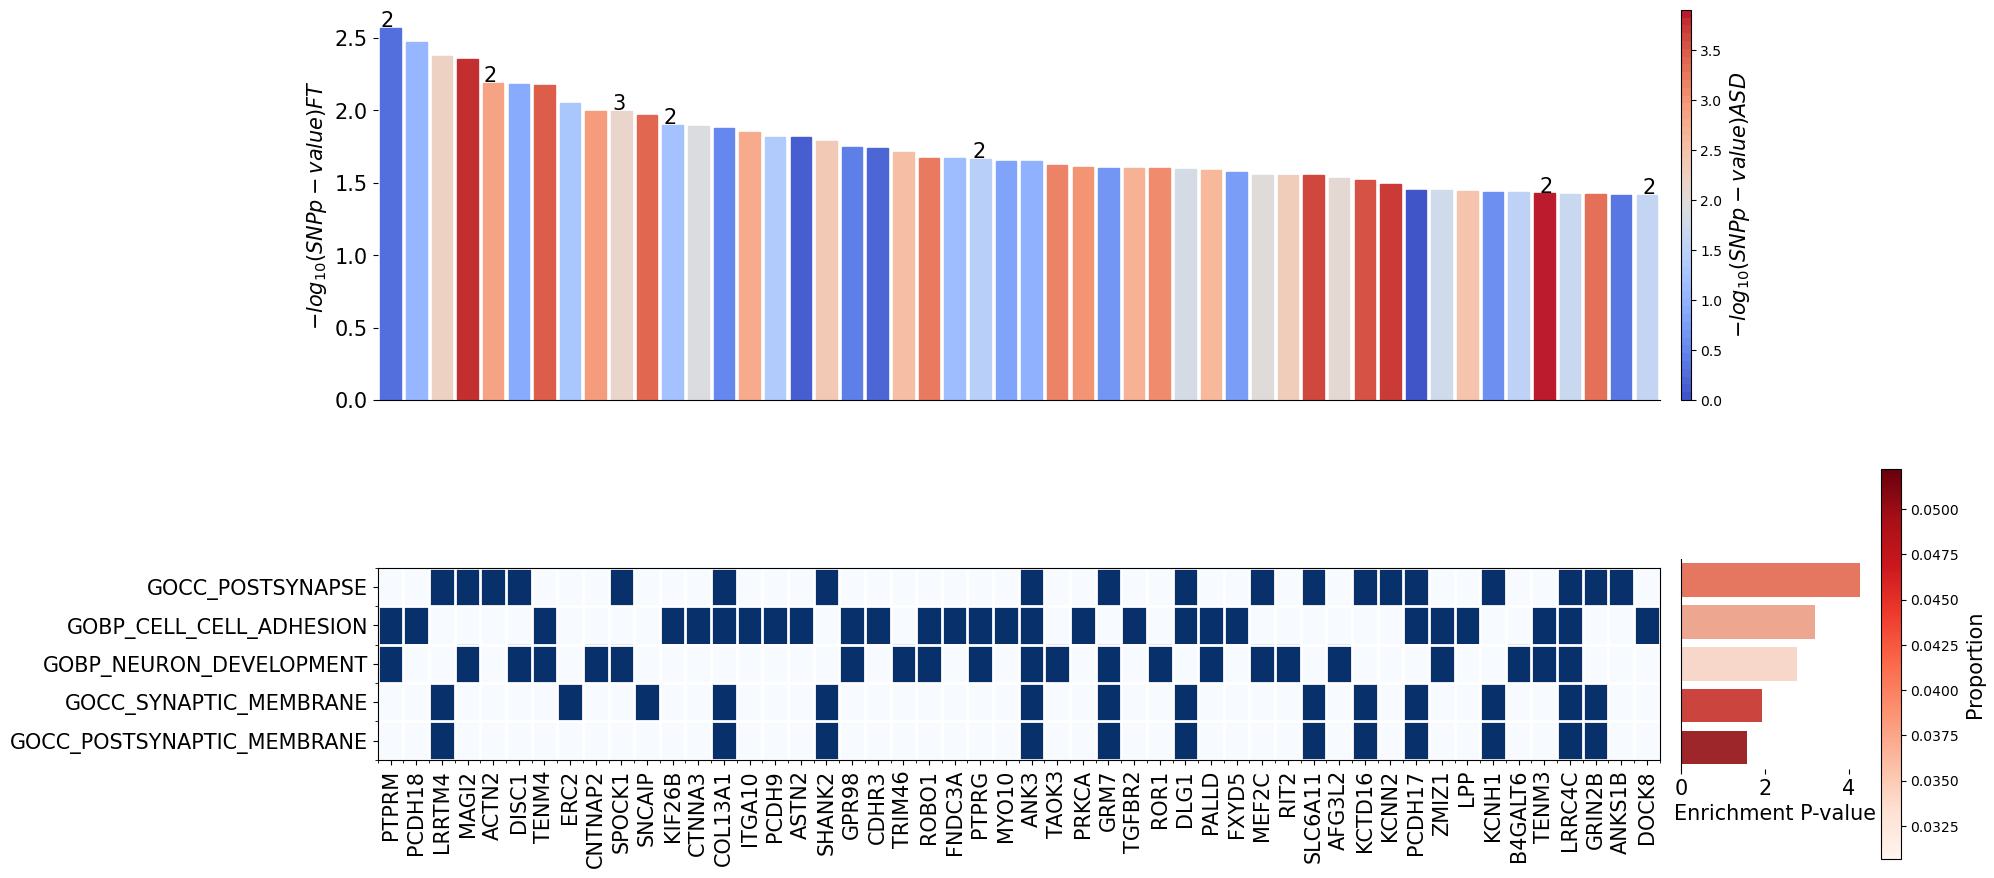

In [242]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(20,18))
gs = fig.add_gridspec(4,8,width_ratios=[1,1,1,1,6,1,1,1])

ax_barplot_top = fig.add_subplot(gs[0,0:6])
ax_heatmap = fig.add_subplot(gs[1,0:6])
ax_enrichment = fig.add_subplot(gs[1,6:8])

heatmap,all_genes,gene_sets = visualisation.Geneset.create_heatmap(FT_best_res,
                                                         genes_set_column = 'GeneSet',
                                                         genes_list_column = 'genes',
                                                         gene_table = FT_best_genes,
                                                         top = 50,
                                                         ordered_by = 'P_FT_vol',
                                                         gene_table_gene_name='Genes_Name'
                                                        )

visualisation.Geneset.visualise_heatmap(heatmap=heatmap,
                                       all_genes=all_genes,
                                       gene_sets=gene_sets,
                                       ax=ax_heatmap)
ax_heatmap.set_aspect(1.5)
ax_heatmap.tick_params('y',rotation=0)
ax_heatmap.tick_params('x',rotation=90)


cbar_ax = fig.add_subplot(gs[0,6])
divider = make_axes_locatable(cbar_ax)
cax = divider.append_axes('left', size='10%', pad=0.05)


visualisation.Geneset.visualise_gene_p_value(gene_table=FT_best_genes,
                                            all_genes=all_genes,
                                            gene_table_gene_name='Genes_Name',
                                            ordered_by='P_FT_vol',
                                            coloured_by='P_ASD',
                                            p_threshold=None,
                                            bar_number='N_SNP',
                                             ax=ax_barplot_top,
                                            cbar_ax = cax,ylabel='FT',cbar_label='ASD')
ax_barplot_top.tick_params('y',labelsize=15)
sns.despine(top=True,left=True,right=True,ax=ax_barplot_top)
sns.despine(top=True,left=True,right=True,bottom=True,ax=cbar_ax)
cbar_ax.axis('off')

aspect = 1
ax_enrichment.set_aspect(aspect)
visualisation.Geneset.visualise_enrichment_p_value(FT_best_res,
                                                   x = 'adjP',
                                                   y='GeneSet',
                                                   xlabel='Enrichment P-value',
                                                   ax=ax_enrichment)
ax_enrichment.tick_params('x',labelsize=15)
ax_enrichment.set_xlabel('Enrichment P-value',fontsize=15)
sns.despine(top=True,bottom=True,right=True,ax=ax_enrichment)
plt.tight_layout()
# fig.savefig('heatmap_with_pval_barplot.pdf')

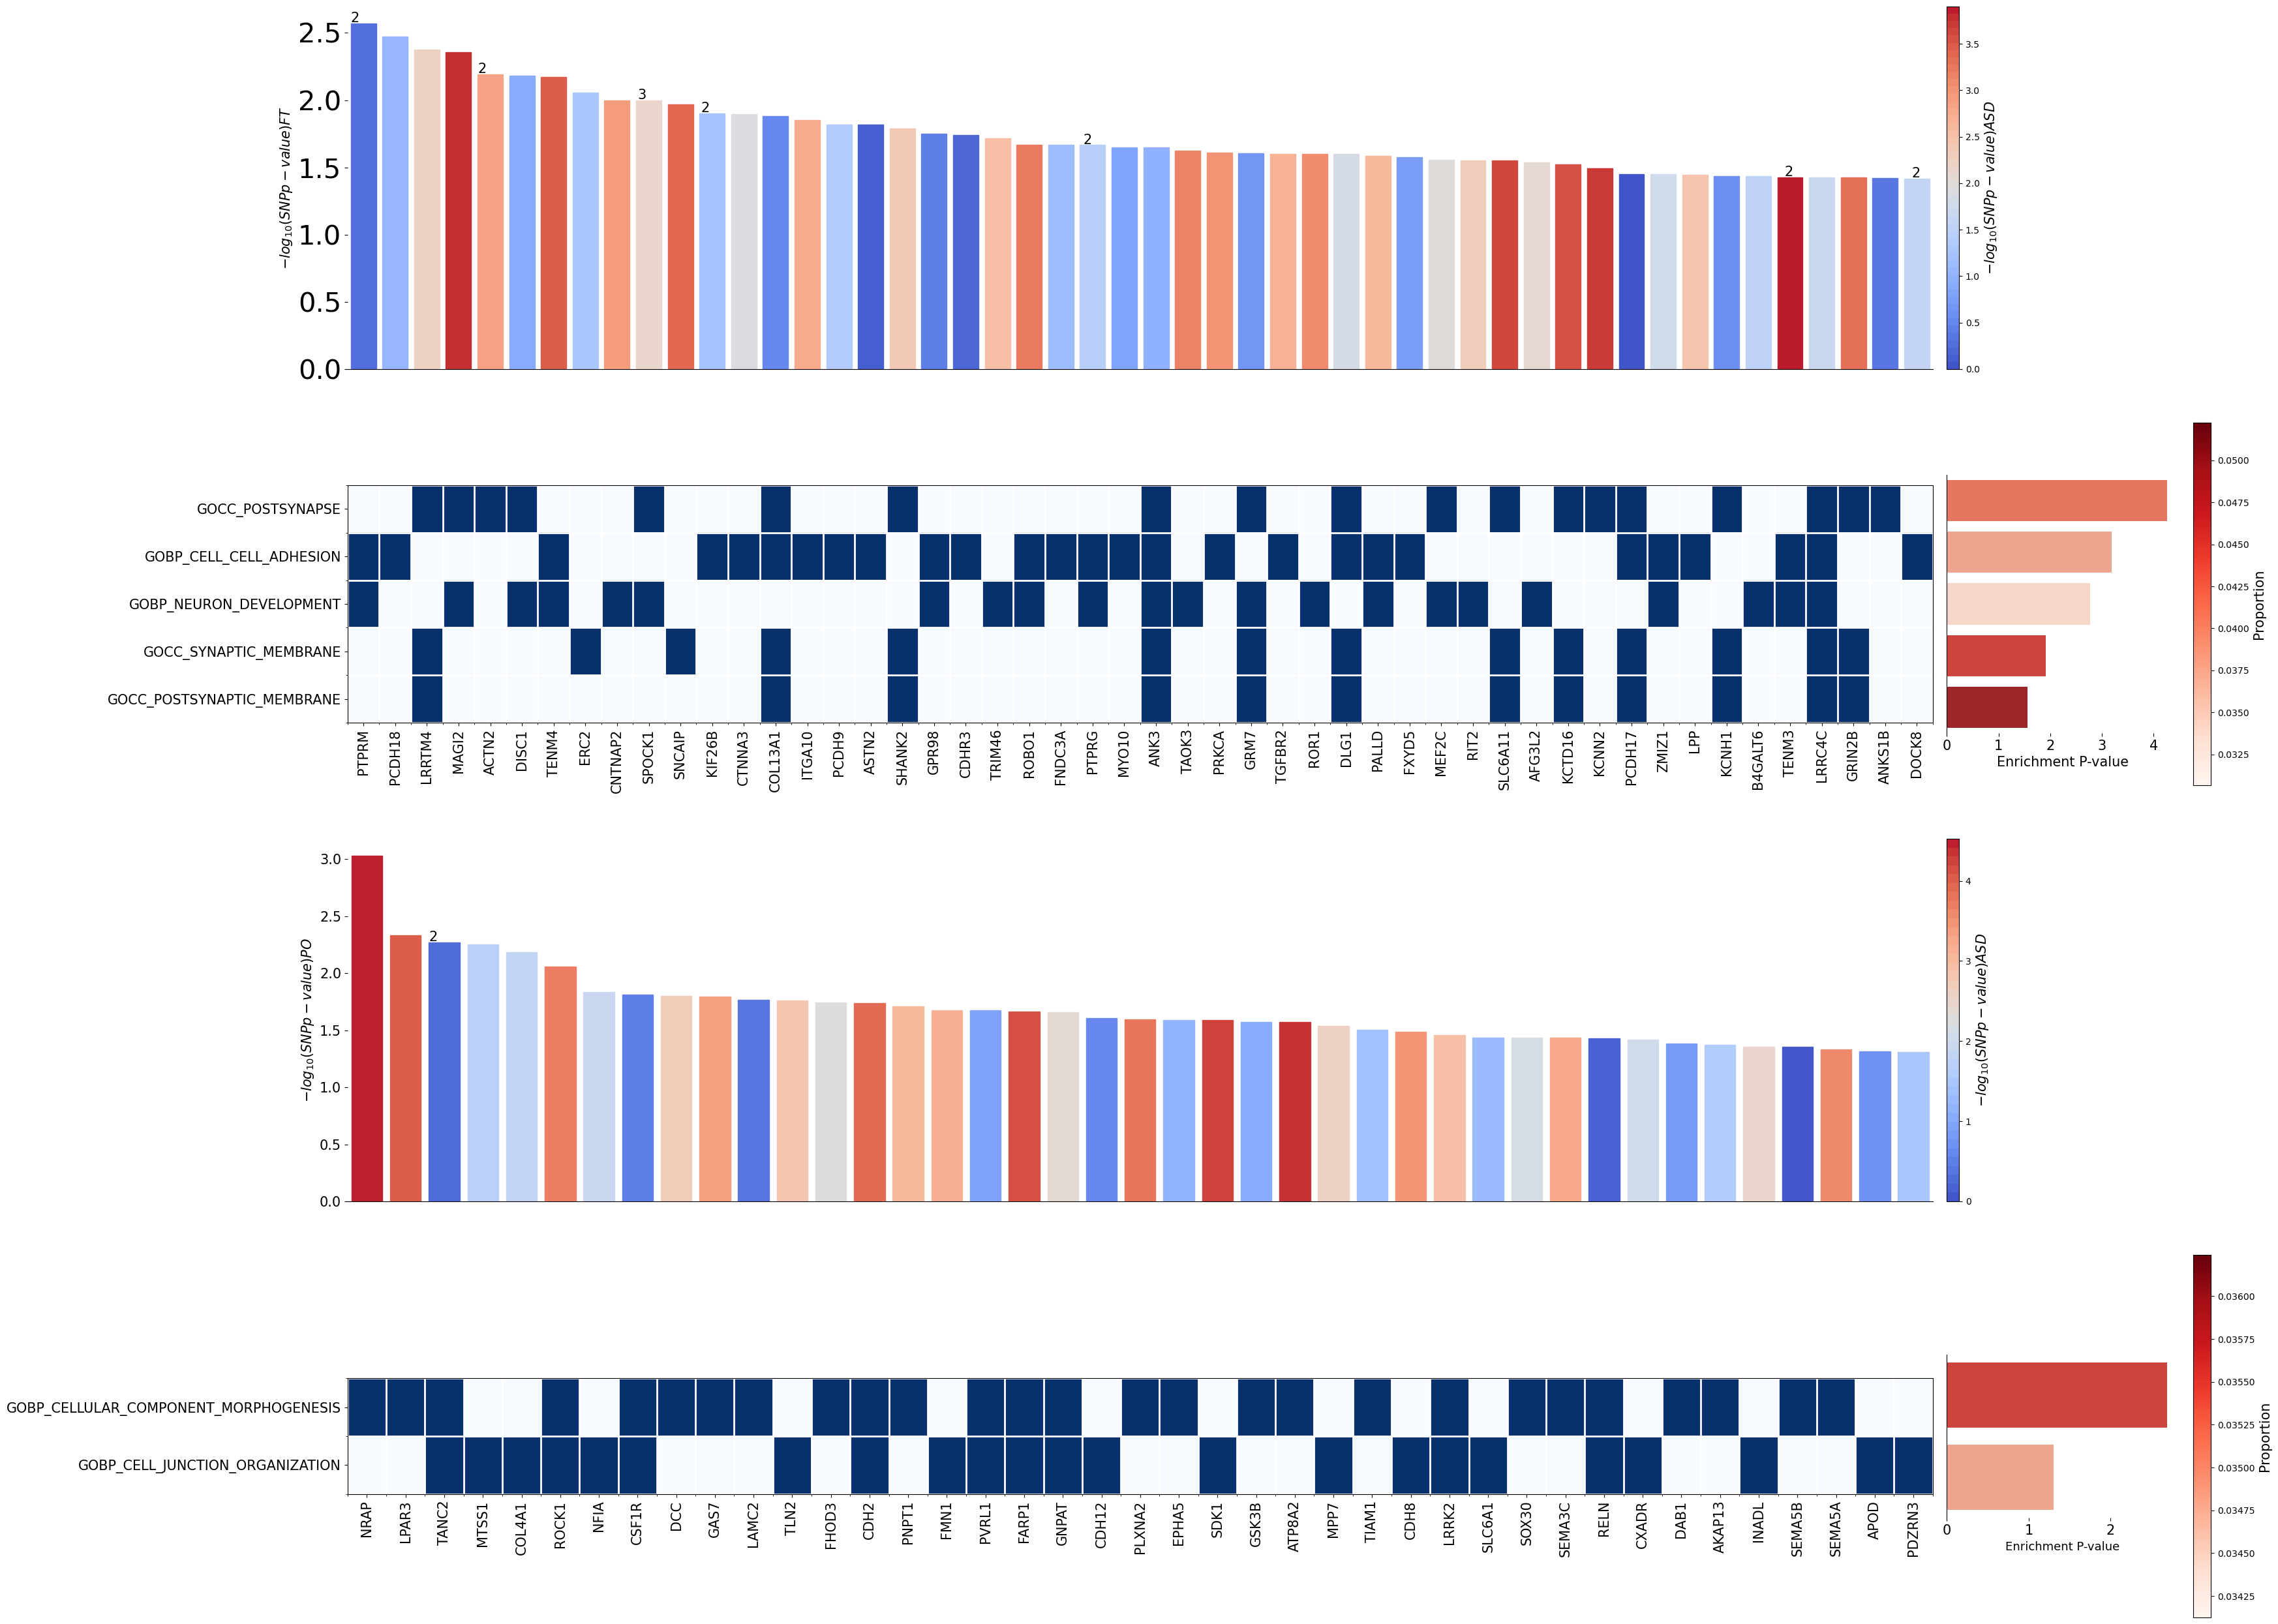

In [145]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(35,25))
gs = fig.add_gridspec(4,8,width_ratios=[6,1,1,1,1,1,1,1])

ax_barplot_top = fig.add_subplot(gs[0,0:6])
ax_heatmap = fig.add_subplot(gs[1,0:6])
ax_enrichment = fig.add_subplot(gs[1,6:8])

heatmap,all_genes,gene_sets = visualisation.Geneset.create_heatmap(FT_best_res,
                                                         genes_set_column = 'GeneSet',
                                                         genes_list_column = 'genes',
                                                         gene_table = FT_best_genes,
                                                         top = 50,
                                                         ordered_by = 'P_FT_vol',
                                                         gene_table_gene_name='Genes_Name'
                                                        )

visualisation.Geneset.visualise_heatmap(heatmap=heatmap,
                                       all_genes=all_genes,
                                       gene_sets=gene_sets,
                                       ax=ax_heatmap)
ax_heatmap.set_aspect(1.5)
ax_heatmap.tick_params('y',rotation=0)
ax_heatmap.tick_params('x',rotation=90)


cbar_ax = fig.add_subplot(gs[0,6])
divider = make_axes_locatable(cbar_ax)
cax = divider.append_axes('left', size='10%', pad=0.05)


visualisation.Geneset.visualise_gene_p_value(gene_table=FT_best_genes,
                                            all_genes=all_genes,
                                            gene_table_gene_name='Genes_Name',
                                            ordered_by='P_FT_vol',
                                            coloured_by='P_ASD',
                                            p_threshold=None,
                                            bar_number='N_SNP',
                                             ax=ax_barplot_top,
                                            cbar_ax = cax,ylabel='FT',cbar_label='ASD')
ax_barplot_top.tick_params('y',labelsize=30)
sns.despine(top=True,left=True,right=True,ax=ax_barplot_top)
sns.despine(top=True,left=True,right=True,bottom=True,ax=cbar_ax)
cbar_ax.axis('off')

aspect = 1
ax_enrichment.set_aspect(aspect)
visualisation.Geneset.visualise_enrichment_p_value(FT_best_res,
                                                   x = 'adjP',
                                                   y='GeneSet',
                                                   xlabel='Enrichment P-value',
                                                   ax=ax_enrichment)
ax_enrichment.tick_params('x',labelsize=15)
ax_enrichment.set_xlabel('Enrichment P-value',fontsize=15)
sns.despine(top=True,bottom=True,right=True,ax=ax_enrichment)

from mpl_toolkits.axes_grid1 import make_axes_locatable

ax_barplot_top = fig.add_subplot(gs[2,0:6])
ax_heatmap = fig.add_subplot(gs[3,0:6])
ax_enrichment = fig.add_subplot(gs[3,6:8])

heatmap,all_genes,gene_sets = visualisation.Geneset.create_heatmap(PO_best_res,
                                                         genes_set_column = 'GeneSet',
                                                         genes_list_column = 'genes',
                                                         gene_table = PO_best_genes,
                                                         top = 50,
                                                         ordered_by = 'P_PO_vol',
                                                         gene_table_gene_name='Genes_Name'
                                                        )

visualisation.Geneset.visualise_heatmap(heatmap=heatmap,
                                       all_genes=all_genes,
                                       gene_sets=gene_sets,
                                       ax=ax_heatmap)
ax_heatmap.set_aspect(1.5)
ax_heatmap.tick_params('y',rotation=0)
ax_heatmap.tick_params('x',rotation=90)


cbar_ax = fig.add_subplot(gs[2,6])
divider = make_axes_locatable(cbar_ax)
cax = divider.append_axes('left', size='10%', pad=0.05)


visualisation.Geneset.visualise_gene_p_value(gene_table=PO_best_genes,
                                            all_genes=all_genes,
                                            gene_table_gene_name='Genes_Name',
                                            ordered_by='P_PO_vol',
                                            coloured_by='P_ASD',
                                            p_threshold=None,
                                            bar_number='N_SNP',
                                             ax=ax_barplot_top,
                                            cbar_ax = cax,ylabel='PO',cbar_label='ASD')
ax_barplot_top.tick_params('y',labelsize=15)
sns.despine(top=True,left=True,right=True,ax=ax_barplot_top)
sns.despine(top=True,left=True,right=True,bottom=True,ax=cbar_ax)
cbar_ax.axis('off')

aspect = 1
ax_enrichment.set_aspect(aspect)
visualisation.Geneset.visualise_enrichment_p_value(PO_best_res,
                                                   x = 'adjP',
                                                   y='GeneSet',
                                                   xlabel='Enrichment P-value',
                                                   ax=ax_enrichment)
ax_enrichment.tick_params('x',labelsize=15)
ax_enrichment.set_xlabel('Enrichment P-value',fontsize=13)
sns.despine(top=True,bottom=True,right=True,ax=ax_enrichment)
plt.tight_layout()
# fig.savefig('../../dataset/preprocessed_dataset/asd/output_plot/PO_heatmap_with_pval_barplot.pdf')

# plt.tight_layout()
# fig.savefig('../../dataset/preprocessed_dataset/asd/output_plot/FT_heatmap_with_pval_barplot.pdf')

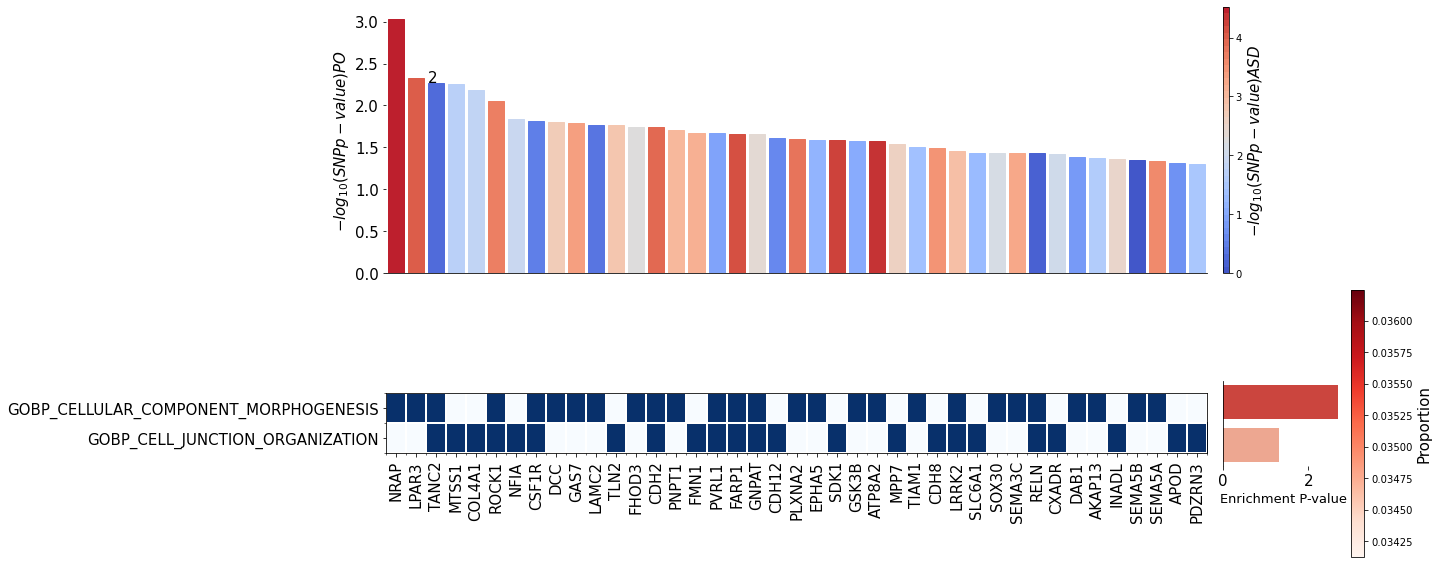

In [18]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(20,8))
gs = fig.add_gridspec(2,8,width_ratios=[6,1,1,1,1,1,1,1])

ax_barplot_top = fig.add_subplot(gs[0,0:6])
ax_heatmap = fig.add_subplot(gs[1,0:6])
ax_enrichment = fig.add_subplot(gs[1,6:8])

heatmap,all_genes,gene_sets = visualisation.Geneset.create_heatmap(PO_best_res,
                                                         genes_set_column = 'GeneSet',
                                                         genes_list_column = 'genes',
                                                         gene_table = PO_best_genes,
                                                         top = 50,
                                                         ordered_by = 'P_PO_vol',
                                                         gene_table_gene_name='Genes_Name'
                                                        )

visualisation.Geneset.visualise_heatmap(heatmap=heatmap,
                                       all_genes=all_genes,
                                       gene_sets=gene_sets,
                                       ax=ax_heatmap)
ax_heatmap.set_aspect(1.5)
ax_heatmap.tick_params('y',rotation=0)
ax_heatmap.tick_params('x',rotation=90)


cbar_ax = fig.add_subplot(gs[0,6])
divider = make_axes_locatable(cbar_ax)
cax = divider.append_axes('left', size='10%', pad=0.05)


visualisation.Geneset.visualise_gene_p_value(gene_table=PO_best_genes,
                                            all_genes=all_genes,
                                            gene_table_gene_name='Genes_Name',
                                            ordered_by='P_PO_vol',
                                            coloured_by='P_ASD',
                                            p_threshold=None,
                                            bar_number='N_SNP',
                                             ax=ax_barplot_top,
                                            cbar_ax = cax,ylabel='PO',cbar_label='ASD')
ax_barplot_top.tick_params('y',labelsize=15)
sns.despine(top=True,left=True,right=True,ax=ax_barplot_top)
sns.despine(top=True,left=True,right=True,bottom=True,ax=cbar_ax)
cbar_ax.axis('off')

aspect = 1
ax_enrichment.set_aspect(aspect)
visualisation.Geneset.visualise_enrichment_p_value(PO_best_res,
                                                   x = 'adjP',
                                                   y='GeneSet',
                                                   xlabel='Enrichment P-value',
                                                   ax=ax_enrichment)
ax_enrichment.tick_params('x',labelsize=15)
ax_enrichment.set_xlabel('Enrichment P-value',fontsize=13)
sns.despine(top=True,bottom=True,right=True,ax=ax_enrichment)
plt.tight_layout()
fig.savefig('../../dataset/preprocessed_dataset/asd/output_plot/PO_heatmap_with_pval_barplot.pdf')

In [14]:
common_best_res

,GeneSet,Category,N_genes,N_overlap,p,adjP,genes,link,Proportion
0,GOCC_SYNAPTIC_MEMBRANE,MSigDB_custom_entrez,369,13,0.000002,0.029845,FOSL1:CNTN5:CACNA1C:UNC13C:GRIN2A:SHISA7:CLSTN...,http://www.gsea-msigdb.org/gsea/msigdb/cards/G...,0.03523


In [15]:
heatmap,all_genes,gene_sets = visualisation.Geneset.create_heatmap(common_best_res,
                                                         genes_set_column = 'GeneSet',
                                                         genes_list_column = 'genes',
                                                         gene_table = combined_best_genes,
                                                         top = 50,
                                                         ordered_by = 'P_PO_vol',
                                                         gene_table_gene_name='Genes_Name'
                                                        )
common_genes = combined_best_genes.loc[combined_best_genes['NAME'].isin(all_genes)][['SNP','STAT_FT_vol','P_FT_vol','STAT_PO_vol','P_PO_vol','P_ASD_FT_vol','NAME','N_SNP']]

common_genes['Gene(SNP)'] = common_genes['NAME'] + '(' + common_genes['SNP'] + ')'

common_genes = common_genes[['Gene(SNP)','STAT_FT_vol','STAT_PO_vol']].set_index('Gene(SNP)').unstack().reset_index()
common_genes['Pheno'] = ['FT' if i == 'STAT_FT_vol' else 'PO' for i in common_genes['level_0']]
common_genes = common_genes.rename(columns={0:'STAT'})
common_genes = common_genes.drop(columns='level_0')


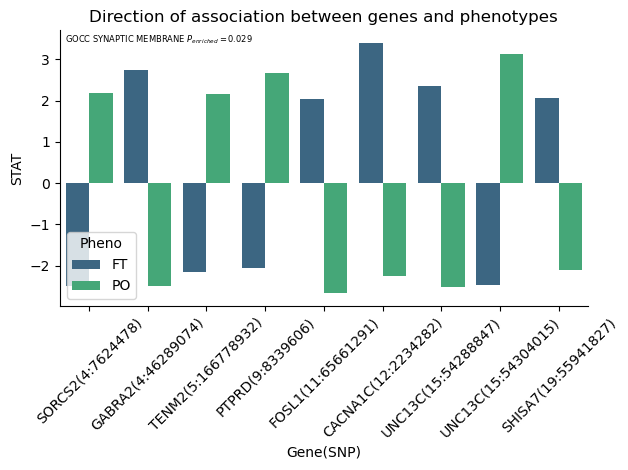

In [149]:
fig,ax=plt.subplots(1,1)
sns.barplot(x='Gene(SNP)',y='STAT',hue='Pheno',data=common_genes,ax=ax,palette='viridis')
ax.tick_params(axis='x',rotation=45)
sns.despine(top=True)
ax.set_title('Direction of association between genes and phenotypes')
ax.text(0.01, 0.99, 'GOCC SYNAPTIC MEMBRANE $P_{enriched}=0.029$', transform=ax.transAxes, fontsize=6, va='top')
plt.tight_layout()
# fig.savefig('combined_genes_stat_plot.pdf')

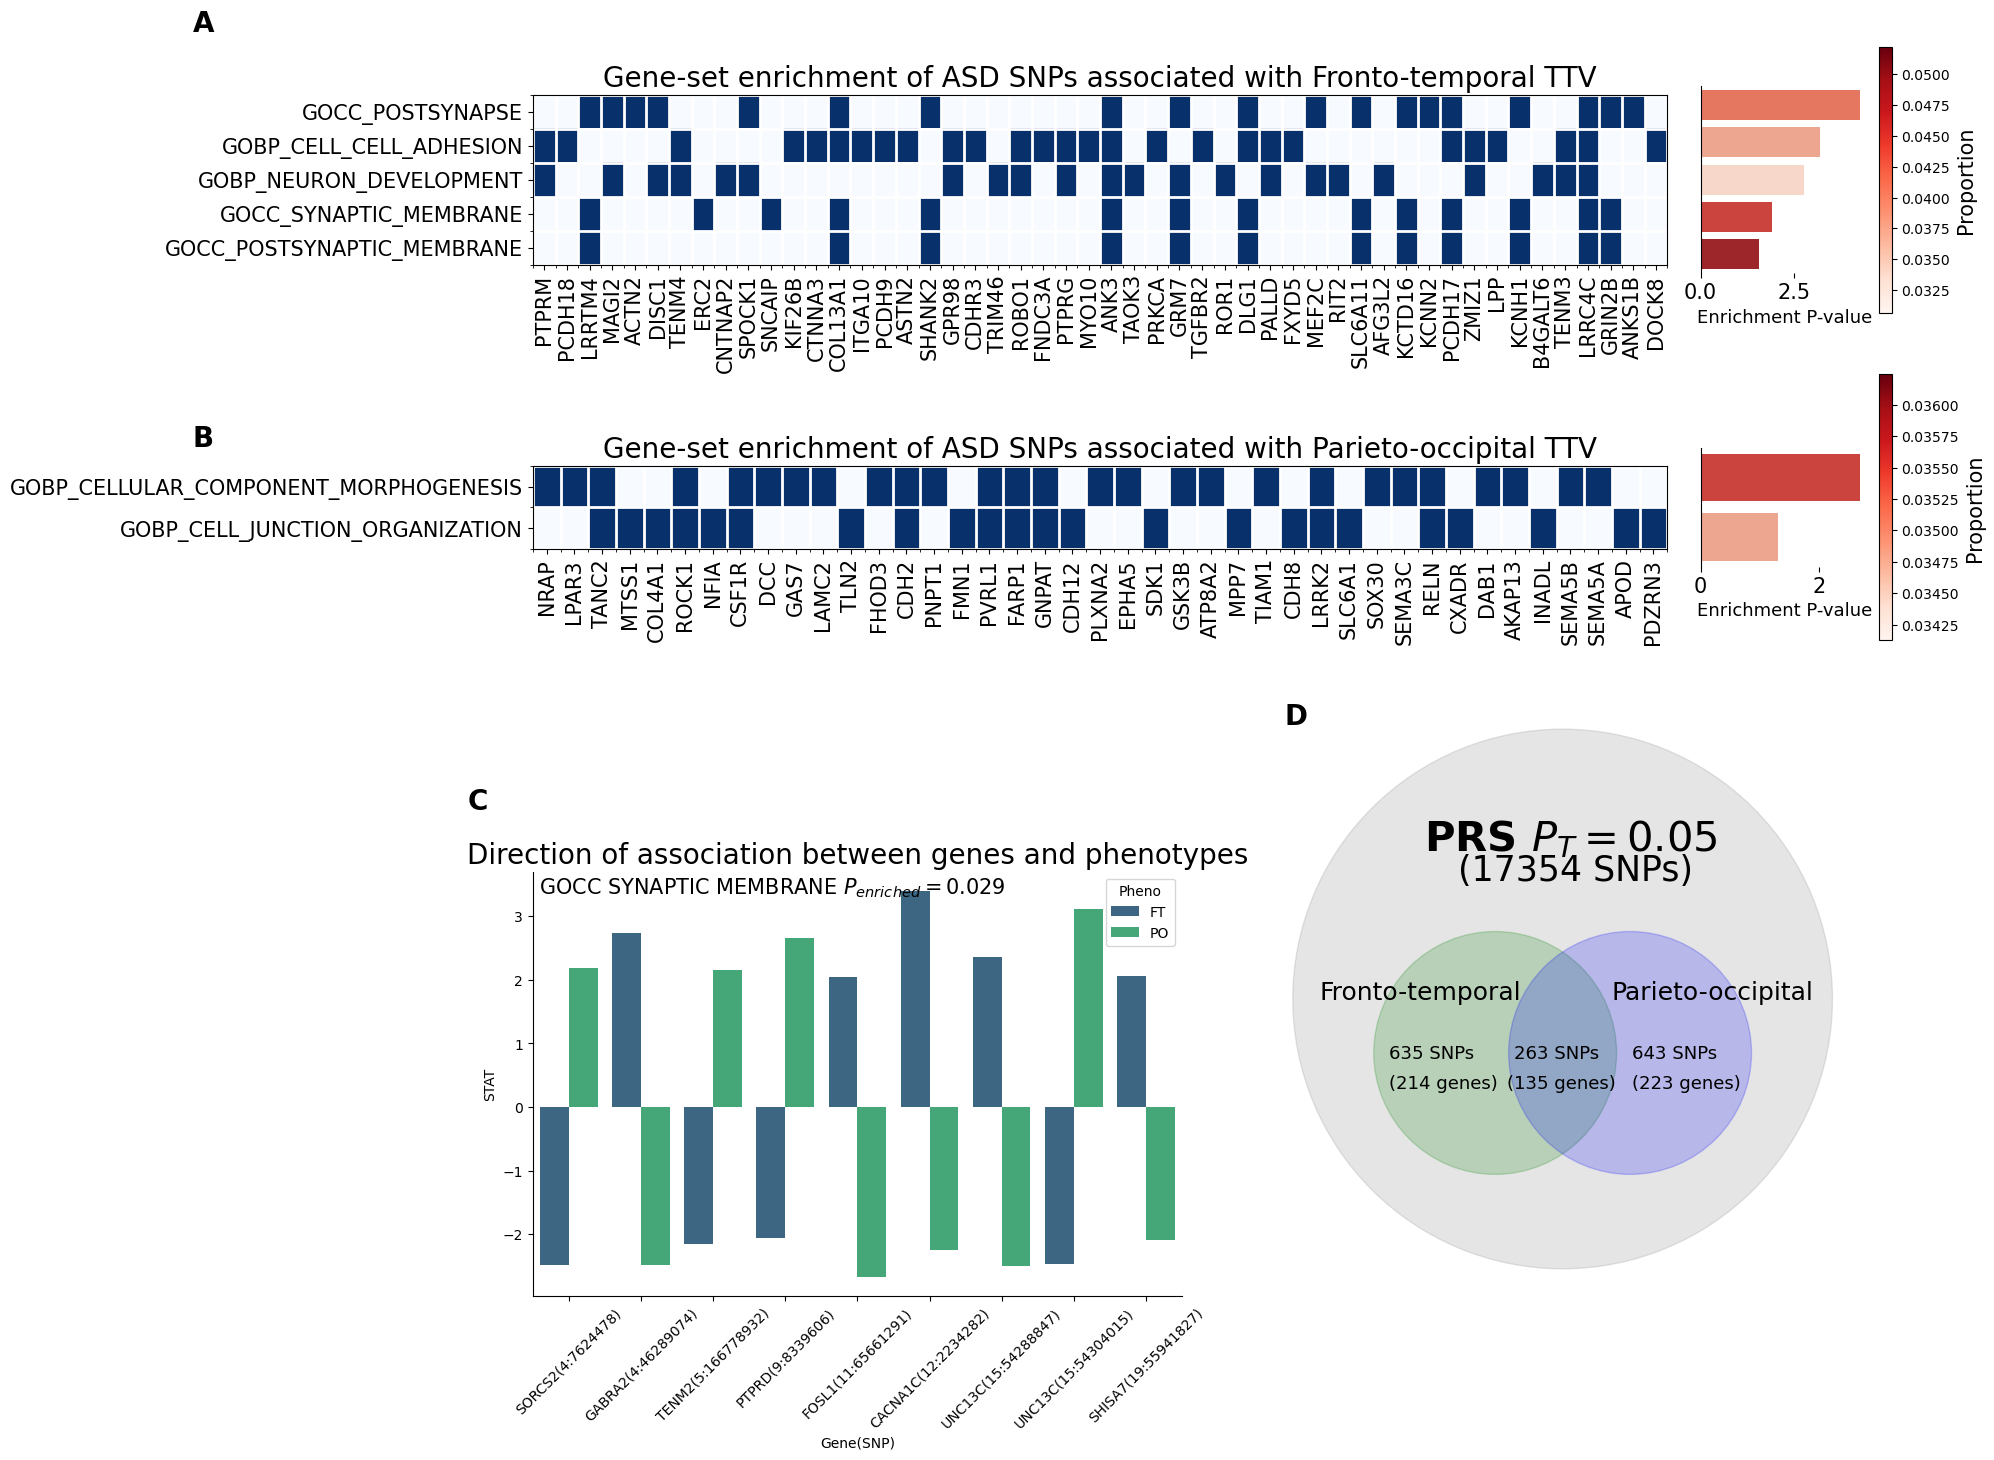

In [17]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(20,15))
gs = fig.add_gridspec(4,8,width_ratios=[6,1,1,1,1,1,1,1])

FT_ax_heatmap = fig.add_subplot(gs[0,0:6])
FT_ax_enrichment = fig.add_subplot(gs[0,6:8])

PO_ax_heatmap = fig.add_subplot(gs[1,0:6])
PO_ax_enrichment = fig.add_subplot(gs[1,6:8])

common_plot = fig.add_subplot(gs[2:,0:2])

circle_plot = fig.add_subplot(gs[2:,2:])

divider = make_axes_locatable(common_plot)
top_remove = divider.append_axes('top',size='20%')

top_remove.set_axis_off()

heatmap,all_genes,gene_sets = visualisation.Geneset.create_heatmap(FT_best_res,
                                                         genes_set_column = 'GeneSet',
                                                         genes_list_column = 'genes',
                                                         gene_table = FT_best_genes,
                                                         top = 50,
                                                         ordered_by = 'P_FT_vol',
                                                         gene_table_gene_name='Genes_Name'
                                                        )

visualisation.Geneset.visualise_heatmap(heatmap=heatmap,
                                       all_genes=all_genes,
                                       gene_sets=gene_sets,
                                       ax=FT_ax_heatmap)
FT_ax_heatmap.set_aspect(1.5)
FT_ax_heatmap.tick_params('y',rotation=0)
FT_ax_heatmap.tick_params('x',rotation=90)

aspect = 1
FT_ax_enrichment.set_aspect(aspect)
visualisation.Geneset.visualise_enrichment_p_value(FT_best_res,
                                                   x = 'adjP',
                                                   y='GeneSet',
                                                   xlabel='Enrichment P-value',
                                                   ax=FT_ax_enrichment)
FT_ax_enrichment.tick_params('x',labelsize=15)
FT_ax_enrichment.set_xlabel('Enrichment P-value',fontsize=13)

FT_ax_heatmap.set_title('Gene-set enrichment of ASD SNPs associated with Fronto-temporal TTV',fontsize=20)

sns.despine(top=True,bottom=True,right=True,ax=FT_ax_enrichment)


heatmap,all_genes,gene_sets = visualisation.Geneset.create_heatmap(PO_best_res,
                                                         genes_set_column = 'GeneSet',
                                                         genes_list_column = 'genes',
                                                         gene_table = PO_best_genes,
                                                         top = 50,
                                                         ordered_by = 'P_PO_vol',
                                                         gene_table_gene_name='Genes_Name'
                                                        )

visualisation.Geneset.visualise_heatmap(heatmap=heatmap,
                                       all_genes=all_genes,
                                       gene_sets=gene_sets,
                                       ax=PO_ax_heatmap)
PO_ax_heatmap.set_aspect(1.5)
PO_ax_heatmap.tick_params('y',rotation=0)
PO_ax_heatmap.tick_params('x',rotation=90)

aspect = 1
PO_ax_enrichment.set_aspect(aspect)
visualisation.Geneset.visualise_enrichment_p_value(PO_best_res,
                                                   x = 'adjP',
                                                   y='GeneSet',
                                                   xlabel='Enrichment P-value',
                                                   ax=PO_ax_enrichment)
PO_ax_enrichment.tick_params('x',labelsize=15)
PO_ax_enrichment.set_xlabel('Enrichment P-value',fontsize=13)
PO_ax_heatmap.set_title('Gene-set enrichment of ASD SNPs associated with Parieto-occipital TTV',fontsize=20)
sns.despine(top=True,bottom=True,right=True,ax=PO_ax_enrichment)

sns.barplot(x='Gene(SNP)',y='STAT',hue='Pheno',data=common_genes,ax=common_plot,palette='viridis')
common_plot.tick_params(axis='x',rotation=45)
sns.despine(top=True,ax=common_plot)
common_plot.set_title('Direction of association between genes and phenotypes',fontsize=20)
common_plot.text(0.01, 0.99, 'GOCC SYNAPTIC MEMBRANE $P_{enriched}=0.029$', transform=common_plot.transAxes, fontsize=15, va='top')

circle1 = plt.Circle((1,1),1,color='grey',alpha=0.2)
circle2 = plt.Circle((0.75,.8),0.45,color='g',alpha=0.2)
circle3 = plt.Circle((1.25,.8),0.45,color='b',alpha=0.2)

circle_plot.add_patch(circle1)
circle_plot.add_patch(circle2)
circle_plot.add_patch(circle3)
circle_plot.text(0.3,0.75, 'PRS ${P_{T}=0.05}$', transform=circle_plot.transAxes, fontsize=30, fontweight='bold')
circle_plot.text(0.35,0.7, '(17354 SNPs)', transform=circle_plot.transAxes, fontsize=25)
circle_plot.text(0.15,0.5, 'Fronto-temporal', transform=circle_plot.transAxes, fontsize=18)
circle_plot.text(0.57,0.5, 'Parieto-occipital', transform=circle_plot.transAxes, fontsize=18)

circle_plot.text(0.25,0.4, '635 SNPs', transform=circle_plot.transAxes, fontsize=13)
circle_plot.text(0.25,0.35, '(214 genes)', transform=circle_plot.transAxes, fontsize=13)

circle_plot.text(0.43,0.4, '263 SNPs', transform=circle_plot.transAxes, fontsize=13)
circle_plot.text(0.42,0.35, '(135 genes)', transform=circle_plot.transAxes, fontsize=13)

circle_plot.text(0.6,0.4, '643 SNPs', transform=circle_plot.transAxes, fontsize=13)
circle_plot.text(0.6,0.35, '(223 genes)', transform=circle_plot.transAxes, fontsize=13)

circle_plot.axis('equal')
circle_plot.text(0.1,1, 'D', transform=circle_plot.transAxes,fontweight='bold', va='top', fontsize=20)

circle_plot.set_axis_off()

FT_ax_heatmap.text(-.3,1.5,'A',transform=FT_ax_heatmap.transAxes, fontsize=20, fontweight='bold', va='top')
PO_ax_heatmap.text(-.3,1.5,'B',transform=PO_ax_heatmap.transAxes, fontsize=20, fontweight='bold', va='top')
common_plot.text(-.1,1.2,'C',transform=common_plot.transAxes, fontsize=20, fontweight='bold', va='top')

plt.tight_layout()

fig.savefig('combined_heatmap_with_circle.png',dpi=300)
fig.savefig('combined_heatmap_with_circle.pdf')